In [21]:
%matplotlib inline

In [21]:
%%bash
qsub \
    -o /u/project/monti/njchiang/code/analogy/jobs/output/ \
    -e /u/project/monti/njchiang/code/analogy/jobs/output/ \
    -V -N cd-rsa-searchlight \
    -l h_data=8G,h_rt=23:59:59 -pe shared 8 \
    -M ${USER} -m bea \
    /u/project/monti/njchiang/code/analogy/analogy-fmri/analysis/scripts/submit/run_cd_rsa.sh


Your job 1078707 ("cd-rsa-searchlight") has been submitted


In [1]:
%%bash

. ~/.bashrc

module load fsl
cd /u/project/monti/Analysis/Analogy

sel=CD

m=graymatter-bin_mask
echo ${m}
mkdir ${SCRATCH}/split
for s in 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16
do
  echo sub-${s}
#   flirt -in analysis/sub-${s}/multivariate/rsa/sub-${s}_${m}_AB_corr_rsaSearchlight.nii.gz \
  flirt -in analysis/sub-${s}/multivariate/searchlight/sub-${s}_${sel}-rsa.nii.gz \
  -out analysis/group/multivariate/rsa/sub-${s}_${sel}-rsa.nii.gz \
  -ref derivatives/standard/MNI152_T1_2mm_brain.nii.gz \
  -applyxfm -init derivatives/sub-${s}/reg/BOLD_template_to_standard.mat
  fslmaths analysis/group/multivariate/rsa/sub-${s}_${sel}-rsa.nii.gz -nan analysis/group/multivariate/rsa/sub-${s}_${sel}-rsa.nii.gz
  fslsplit analysis/group/multivariate/rsa/sub-${s}_${sel}-rsa.nii.gz ${SCRATCH}/split/sub-${s}_
done
# fslmerge -t analysis/group/multivariate/rsa/group_${m}_AB.nii.gz analysis/group/multivariate/rsa/sub*_${m}_AB_rsaSearchlight.nii.gz

fslmerge -t analysis/group/multivariate/rsa/pearson/group_${sel}_w2vc ${SCRATCH}/split/*0000.nii.gz 
fslmerge -t analysis/group/multivariate/rsa/pearson/group_${sel}_w2vd ${SCRATCH}/split/*0001.nii.gz 
fslmerge -t analysis/group/multivariate/rsa/pearson/group_${sel}_bart ${SCRATCH}/split/*0002.nii.gz 
fslmerge -t analysis/group/multivariate/rsa/pearson/group_${sel}_w2vcdist ${SCRATCH}/split/*0003.nii.gz 
fslmerge -t analysis/group/multivariate/rsa/pearson/group_${sel}_w2vddist ${SCRATCH}/split/*0004.nii.gz 
fslmerge -t analysis/group/multivariate/rsa/pearson/group_${sel}_bartdist ${SCRATCH}/split/*0005.nii.gz 
# fslmerge -t analysis/group/multivariate/rsa/group_gm_AB_designAndBART9 analysis/group/multivariate/rsa/split/*0006.nii.gz 
# fslmerge -t analysis/group/multivariate/rsa/group_gm_AB_designAndw2vDiff analysis/group/multivariate/rsa/split/*0007.nii.gz 
# fslmerge -t analysis/group/multivariate/rsa/group_gm_AB_designAndw2vConcat analysis/group/multivariate/rsa/split/*0008.nii.gz 
# fslmerge -t analysis/group/multivariate/rsa/group_gm_AB_BART9Andw2vConcat analysis/group/multivariate/rsa/split/*0009.nii.gz 

rm analysis/group/multivariate/rsa/sub*_${sel}-rsa.nii.gz
rm -r ${SCRATCH}/split


#       flirt -in analysis/sub-${s}/encoding/sub-${s}-${m}-cope-LSS_${sel}_cv-relation \

graymatter-bin_mask
sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-08
sub-09
sub-10
sub-11
sub-12
sub-13
sub-14
sub-15
sub-16


In [ ]:
%%bash

. ~/.bashrc
module load fsl

n=1000
cd /u/project/monti/Analysis/Analogy

for m in w2vc w2vd bart w2vcdist w2vddist bartdist # rstpostprob79 rstpostprob9 w2vdiff concatword
do
    randomise -i analysis/group/multivariate/rsa/pearson/group_CD_${m} \
      -o analysis/group/multivariate/rsa/pearson/n${n}-CD_${m} \
      -m derivatives/standard/masks/grayMatter \
      -n ${n} -1 -T --uncorrp -v 10
done


In [1]:
import json
import sys
import os
os.chdir("..")
from datetime import datetime
# import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from analysis.fmri.analogy_utils import analysisSettings, contrastSettings, projectSettings, \
    PATHS, order, \
    pu, pa, pv, rsa, \
    compile_models, save_rois, load_rois, load_betas
from analysis.fmri.analogy_rsa import get_model_rdms, get_model_rdm
# from analysis.BaseSearchlight import RSASearchlight
paths = PATHS

/u/home/n/njchiang/.conda/envs/fmri/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Loading JSON config from config/analyses.json
Loading JSON config from config/contrasts.json
Loading label file from: labels/trialorder_rsa_absorted.csv


In [2]:


class CVSearchlight:
    def __init__(self, sub, mask_file=None, settings=analysisSettings["searchlight"], phase="AB", logger=None, phase_equals=True, phase_val=1):
        self.logger = logger
        self.sub = sub
        self.phase = phase
        self.target = "{}MainRel".format(phase.upper())
        self.mask = pu.load_img(mask_file, logger=logger) if mask_file else None
        self.fmri_data, self.labels, self.bg_image = load_betas(projectSettings, sub, t="cope-LSS", logger=logger)
        self.select_data(phase, phase_equals, phase_val)
        self.init_sl(settings)
        self.outpath = os.path.join(paths["root"], "analysis", sub, "multivariate", "searchlight", "mvpa", "{}_{}-cvsl.nii.gz".format(sub, phase))

    def select_data(self, phase="AB", equals=True, val=1):
        if equals:
            self.selector = self.labels[self.labels[phase] == val]
        else:
            self.selector = self.labels[self.labels[phase] != val]
        self.fmri_data = pu.index_img(self.fmri_data, self.selector.index)
        self.labels = self.labels.loc[self.selector.index]
        
    def init_sl(self, settings):
        settings["estimator"] = Pipeline(steps=[  # (
            # "variance_threshold", VarianceThreshold()),
            ("scaling", StandardScaler()),
        #            ("feature_select", SelectPercentile(f_classif, percentile=20)),
        #            ("feature_select", SelectKBest(f_classif, k=100)),
            ("svm", LinearSVC(C=0.05))
        #            ("plr", LogisticRegression(C=0.05, penalty="l1", tol=0.01))
        ])
        self.cv = LeaveOneGroupOut()
        self.sl_options = settings

    def run(self, **unused):
        result = pa.searchlight(self.fmri_data, self.selector[self.target],
                                m=self.mask, cv=self.cv,
                                groups=self.selector['chunks'], write=False,
                                logger=self.logger, **self.sl_options)
        pu.data_to_img(result.scores_, self.bg_image, logger=self.logger).to_filename(self.outpath)
        return result
    
class RSASearchlight(CVSearchlight):
    def __init__(self, sub, mask_file=None, settings=analysisSettings["searchlight"], phase="AB", logger=None, phase_equals=True, phase_val=1):
        super(RSASearchlight, self).__init__(sub, mask_file, settings=settings, phase=phase, logger=logger, phase_equals=phase_equals, phase_val=phase_val)
        self.outpath = os.path.join(paths["root"], "analysis", sub, "multivariate", "searchlight", "{}_{}-rsa.nii.gz".format(sub, phase))
    def select_data(self, phase="AB", equals=True, val=1):
        # will be a little more complex
        if equals:
            self.selector = self.labels[self.labels[phase] == val].sort_values(["SubRel", "TrialTag"])
        else:
            self.selector = self.labels[self.labels[phase] != val]
        self.fmri_data = pu.index_img(self.fmri_data, self.selector.index)
        self.labels = self.labels.loc[self.selector.index]

    def init_sl(self, settings):
        settings["rdm_metric"] = "correlation"
        self.sl_options = settings

    def run(self, modelrdms):
        result = pa.searchlight_rsa(
            self.fmri_data, modelrdms,
            m=self.mask, write=False,
            logger=self.logger, **self.sl_options)
        pu.data_to_img(result.scores_, self.bg_image, logger=self.logger).to_filename(self.outpath)
        return result
    
    

In [3]:
modelnames = [
            "mainrel", "rel",
            "numchar", "humanratings", "typicality",
            "w2vdiff", "concatword",
            "rstpostprob9", "rstpostprob79"]
raw_models_df = pu.load_labels(os.path.join(paths["code"], "labels/raw_models.csv"))
model_rdms = get_model_rdms(raw_models_df, modelnames)
modelrdms = model_rdms[(model_rdms.type == "full")].dropna(axis=1).values[:, 2:].astype(np.float64)

Loading label file from: /u/project/monti/Analysis/Analogy/code/analogy-fmri/labels/raw_models.csv


In [4]:
raw_models_df

,ABTag,mainrel_1,mainrel_2,mainrel_3,subrel_1,subrel_2,subrel_3,subrel_4,subrel_5,subrel_6,...,concatword_595,concatword_596,concatword_597,concatword_598,concatword_599,concatword_600,typicality,numchar,MainCond,SubCond
0,acceleration:speed,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.07861,0.10254,0.00185,0.15234,-0.33398,-0.00705,68.0,18.0,1,3
1,acceleration:speed,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.07861,0.10254,0.00185,0.15234,-0.33398,-0.00705,68.0,18.0,1,3
2,accept:reject,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.01624,0.23047,0.04932,0.04932,0.05737,0.05737,33.3,13.0,2,4
3,accept:reject,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.01624,0.23047,0.04932,0.04932,0.05737,0.05737,33.3,13.0,2,4
4,accident:damage,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.17285,0.03271,-0.13477,-0.25586,-0.08447,-0.08936,41.2,15.0,3,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,witty:dumb,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.26562,0.07227,0.30664,-0.23828,-0.03857,0.11914,18.0,10.0,2,6
284,work:earn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.16406,0.12158,0.06250,0.01202,0.13574,-0.09131,28.0,9.0,3,9
285,work:earn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.16406,0.12158,0.06250,0.01202,0.13574,-0.09131,28.0,9.0,3,9
286,workout:sweat,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.28516,0.02026,-0.18262,0.06885,-0.10742,-0.24414,14.0,13.0,3,7


In [6]:
def get_cd_models(raw_model_dfs, trials):
    bart_df = (raw_models_df[::2]
            .reset_index(drop=True)
            .set_index("ABTag")[
                [c for c in raw_models_df.columns if "rstpostprob79" in c]
            ])  
    
    
    
    w2vc_df = (raw_models_df[::2]
                .reset_index(drop=True)
                .set_index("ABTag")[
                    [c for c in raw_models_df.columns if "concatword" in c]
                ])  

    w2vd_df = (raw_models_df[::2]
                .reset_index(drop=True)
                .set_index("ABTag")[
                    [c for c in raw_models_df.columns if "w2vdiff" in c]
                ])
    
    
    def _get_dist_model(df):
        dsts = np.concatenate(
        [rsa.pdist(df.loc[
            [t.split("::")[0], t.split("::")[1]]], 
               metric="cosine") 
             for t in trials.TrialTag])
        return rsa.rdm(dsts.reshape(-1, 1), metric="euclidean")
    
    w2vc = rsa.rdm(w2vc_df.loc[[t for t in trials.CDTag]], metric="cosine")
    w2vc_dist_cd = _get_dist_model(w2vc_df)
    
    w2vd_cd = rsa.rdm(w2vd_df.loc[[t for t in trials.CDTag]], metric="cosine")
    w2vd_dist_cd = _get_dist_model(w2vd_df)
    
    bart_cd = rsa.rdm(bart_df.loc[[t for t in trials.CDTag]], metric="cosine")
    bart_dist_cd = _get_dist_model(bart_df)
    
    models = np.array([w2vc, w2vd_cd, bart_cd, w2vc_dist_cd, w2vd_dist_cd, bart_dist_cd])
    modelnames = "Word2vec-concat", "Word2vec-diff", "BART", "w2vc-dist", "w2vd-dist", "BART-dist"
    

    return models, modelnames

In [16]:
logger=None
phase = "CD"
sub = "sub-01"
roi = "dfc-left-ba10_mask"
# roi = "graymatter-bin_mask"
mask_file = os.path.join(paths["root"], "derivatives", sub, "masks", "{}.nii.gz".format(roi))



sl = RSASearchlight(sub, mask_file, phase=phase, settings=analysisSettings["searchlight"], logger=logger)

Reading file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/masks/dfc-left-ba10_mask.nii.gz
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/func/sub-01_task-analogy_run-01_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/func/sub-01_task-analogy_run-02_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/func/sub-01_task-analogy_run-03_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/func/sub-01_task-analogy_run-04_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/func/sub-01_task-analogy_run-05_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy/derivatives/sub-01/func/sub-01_task-analogy_run-06_events.csv
centering image
Loading label file from: /u/project/monti/Analysis/Analogy

In [17]:
sl.fmri_data.shape

(104, 104, 60, 288)

In [18]:
sl.fmri_data = pu.index_img(sl.fmri_data, sl.selector.Match == '1')
sl.labels = sl.labels[sl.selector.Match == '1']
sl.selector = sl.labels

Slicing image


In [20]:
sl.labels

,Onset,Duration,TrialTag,ABTag,CDTag,Match,ABMainRel,CDMainRel,ABSubRel,CDSubRel,...,ProbeCorr,ProbeArr,AB,CD,Probe,Intensity,TrialType,chunks,MainRel,SubRel
577,98.5530,2.0085,big:large::option:choice,None,option:choice,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,6,1,1
103,264.7922,2.0195,boat:ship::big:large,None,big:large,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,1,1,1
280,164.8085,2.0088,boat:ship::pants:trousers,None,pants:trousers,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,3,1,1
184,200.8329,2.0155,couch:sofa::kid:child,None,kid:child,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,2,1,1
406,212.2205,2.0165,cute:adorable::raise:elevate,None,raise:elevate,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,36.8364,2.0080,speak:express::flee:escape,None,flee:escape,1,None,3,None,9,...,0,0,0,1,0,1.0,CD,7,3,9
517,224.7260,2.0095,speak:express::ignite:burn,None,ignite:burn,1,None,3,None,9,...,0,0,0,1,0,1.0,CD,5,3,9
61,157.8567,2.0111,trim:shorten::study:learn,None,study:learn,1,None,3,None,9,...,0,0,0,1,0,1.0,CD,1,3,9
70,181.0673,2.0104,wash:clean::cook:eat,None,cook:eat,1,None,3,None,9,...,0,0,0,1,0,1.0,CD,1,3,9


In [5]:
bart_df = (raw_models_df[::2]
            .reset_index(drop=True)
            .set_index("ABTag")[
                [c for c in raw_models_df.columns if "rstpostprob79" in c]
            ]).iloc[sl.labels[sl.labels.CD == 1].index]  

NameError: name 'sl' is not defined

In [ ]:
models, modelnames = get_cd_models(raw_models_df, sl.labels[(sl.selector.Match == '1')])

In [41]:
sl.labels[(sl.selector.Match == '1')]

,Onset,Duration,TrialTag,ABTag,CDTag,Match,ABMainRel,CDMainRel,ABSubRel,CDSubRel,...,ProbeCorr,ProbeArr,AB,CD,Probe,Intensity,TrialType,chunks,MainRel,SubRel
577,98.5530,2.0085,big:large::option:choice,None,option:choice,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,6,1,1
103,264.7922,2.0195,boat:ship::big:large,None,big:large,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,1,1,1
280,164.8085,2.0088,boat:ship::pants:trousers,None,pants:trousers,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,3,1,1
184,200.8329,2.0155,couch:sofa::kid:child,None,kid:child,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,2,1,1
406,212.2205,2.0165,cute:adorable::raise:elevate,None,raise:elevate,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,36.8364,2.0080,speak:express::flee:escape,None,flee:escape,1,None,3,None,9,...,0,0,0,1,0,1.0,CD,7,3,9
517,224.7260,2.0095,speak:express::ignite:burn,None,ignite:burn,1,None,3,None,9,...,0,0,0,1,0,1.0,CD,5,3,9
61,157.8567,2.0111,trim:shorten::study:learn,None,study:learn,1,None,3,None,9,...,0,0,0,1,0,1.0,CD,1,3,9
70,181.0673,2.0104,wash:clean::cook:eat,None,cook:eat,1,None,3,None,9,...,0,0,0,1,0,1.0,CD,1,3,9


In [42]:
sl.selector[(sl.selector.Match == '1')]

,Onset,Duration,TrialTag,ABTag,CDTag,Match,ABMainRel,CDMainRel,ABSubRel,CDSubRel,...,ProbeCorr,ProbeArr,AB,CD,Probe,Intensity,TrialType,chunks,MainRel,SubRel
577,98.5530,2.0085,big:large::option:choice,None,option:choice,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,6,1,1
103,264.7922,2.0195,boat:ship::big:large,None,big:large,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,1,1,1
280,164.8085,2.0088,boat:ship::pants:trousers,None,pants:trousers,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,3,1,1
184,200.8329,2.0155,couch:sofa::kid:child,None,kid:child,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,2,1,1
406,212.2205,2.0165,cute:adorable::raise:elevate,None,raise:elevate,1,None,1,None,1,...,0,0,0,1,0,1.0,CD,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,36.8364,2.0080,speak:express::flee:escape,None,flee:escape,1,None,3,None,9,...,0,0,0,1,0,1.0,CD,7,3,9
517,224.7260,2.0095,speak:express::ignite:burn,None,ignite:burn,1,None,3,None,9,...,0,0,0,1,0,1.0,CD,5,3,9
61,157.8567,2.0111,trim:shorten::study:learn,None,study:learn,1,None,3,None,9,...,0,0,0,1,0,1.0,CD,1,3,9
70,181.0673,2.0104,wash:clean::cook:eat,None,cook:eat,1,None,3,None,9,...,0,0,0,1,0,1.0,CD,1,3,9


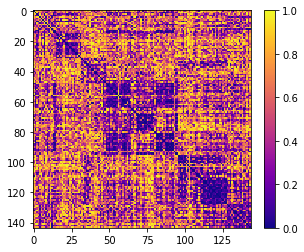

In [44]:

pv.plot_rdm(rsa.squareform(models[0]), cmap="plasma")


In [57]:
mod

9

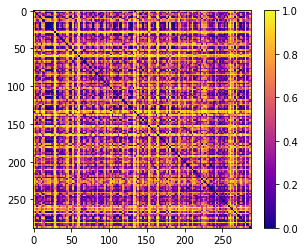

In [61]:
pv.plot_rdm(modelrdms[8], cmap="plasma")


In [36]:
x = sl.fmri_data.get_data()[10:13, 10:13, 10:13, :].transpose([3, 0, 1, 2]).reshape(288, -1)


In [38]:

roi_rdm = rsa.rdm(x, metric="correlation")
1 - rsa.rdm(np.vstack([roi_rdm, modelrdms]).astype(np.float64), metric="spearman", return_p=False)

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  9.82469662e-01,  5.85908063e-02,  9.73772398e-01,
        1.18204647e-02,  5.85281721e-02,  2.27966851e-01,  2.26763377e-01,
        2.02276016e-01,  6.22378443e-02,  9.91147549e-01,  1.81030781e-02,
        7.68722766e-02,  2.55885919e-01,  2.57221443e-01,  2.23429716e-01,
        5.96707023e-02, -2.33656070e-02,  8.89080514e-03,  7.87777434e-02,
        8.81572226e-02,  9.90299552e-02,  2.91543295e-02,  7.97978580e-02,
        2.47825673e-01,  2.53172028e-01,  2.24169529e-01, -1.04395299e-03,
        9.88890987e-04,  1.01426331e-01,  1.43048380e-01,  3.43337647e-01,
        1.47645282e-01,  2.06217201e-01,  1.58117879e-01,  1.48535666e-01,
        8.60851997e-01])

In [43]:
sl.labels

,Onset,Duration,TrialTag,ABTag,CDTag,Match,ABMainRel,CDMainRel,ABSubRel,CDSubRel,...,ProbeCorr,ProbeArr,AB,CD,Probe,Intensity,TrialType,chunks,MainRel,SubRel
0,3.0292,2.0088,up:down::high:low,up:down,None,None,2,None,5,None,...,0,0,1,0,0,1.0,AB,1,2,5
1,6.1673,2.0220,up:down::high:low,None,high:low,1,None,2,None,5,...,0,0,0,1,0,1.0,CD,1,2,5
2,8.9805,0.5393,up:down::high:low,up:down,high:low,1,2,2,5,5,...,3,1,0,0,1,1.0,Probe,1,None,None
3,10.5476,2.0100,day:evening::speak:express,day:evening,None,None,2,None,6,None,...,0,0,1,0,0,1.0,AB,1,2,6
4,13.5209,2.0214,day:evening::speak:express,None,speak:express,0,None,3,None,9,...,0,0,0,1,0,1.0,CD,1,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,257.1797,2.0131,burnish:shine::trim:shorten,None,trim:shorten,1,None,3,None,9,...,0,0,0,1,0,1.0,CD,8,3,9
860,260.0445,0.5026,burnish:shine::trim:shorten,burnish:shine,trim:shorten,1,3,3,9,9,...,3,1,0,0,1,1.0,Probe,8,None,None
861,261.5684,2.0095,advertise:promote::wash:clean,advertise:promote,None,None,3,None,9,None,...,0,0,1,0,0,1.0,AB,8,3,9
862,265.4092,2.0202,advertise:promote::wash:clean,None,wash:clean,1,None,3,None,9,...,0,0,0,1,0,1.0,CD,8,3,9


In [44]:
sl.phase

'CD'